In [1]:
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
import os
from tqdm import tqdm
import requests
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt

data_path = data_path = pathlib.Path().resolve().parent.parent / "rn_home" / "data"
rlpolk_data_path = data_path / "rlpolk_data"
vin_matching_path = data_path / "vin_matching"

# Define required functions

In [2]:
def try_divide(a,b):
    try:
        return round(a/b,2)
    except:
        return np.NaN

# Import data

In [117]:
rlp_raw = pd.read_csv(rlpolk_data_path / "rlpolk_data_matched.csv", index_col = [0])
evs_raw = rlp_raw[rlp_raw["Fuel Type - Primary"]=="Electric"]

In [4]:
rlp = rlp_raw.copy(deep=True)

# Prepare block group allocations

In [114]:
mun_evs = pd.read_csv(data_path / "municipal_evs_zips_blockgroups" / "evs_geocoded_zip_blockgroup.csv")

/tmp/ipykernel_3251295/3968569660.py:1: DtypeWarning: Columns (14,19,20,47,48,83) have mixed types. Specify dtype option on import or set low_memory=False.
  mun_evs = pd.read_csv(data_path / "municipal_evs_zips_blockgroups" / "evs_geocoded_zip_blockgroup.csv")


In [98]:
cols_keep = ['Status', 'Region', 'Postal', 'PostalExt', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID']
mun_evs = mun_evs.loc[:,cols_keep]
mun_evs = mun_evs.loc[(mun_evs["Region"]=="Connecticut") & (mun_evs["Status"]=="M"), :]
mun_evs["Postal"] = mun_evs["Postal"].astype(int)

In [101]:
mun_evs_zipgroups = mun_evs.groupby(["Postal", "GEOID"]).count().reset_index()[["Postal", "GEOID", "Status"]].rename(columns={"Status":"Count"})

In [105]:
mun_evs_zipgroups["pct_within_zip"] = mun_evs_zipgroups["Count"] / mun_evs_zipgroups.groupby("Postal")["Count"].transform('sum')

In [124]:
mun_evs_zipgroups[["Postal", "GEOID", "pct_within_zip"]]

,Postal,GEOID,pct_within_zip
0,6001,9.003460e+10,0.009259
1,6001,9.003462e+10,0.003086
2,6001,9.003462e+10,0.104938
3,6001,9.003462e+10,0.064815
4,6001,9.003462e+10,0.037037
...,...,...,...
2441,6907,9.001021e+10,0.113208
2442,6907,9.001021e+10,0.245283
2443,6907,9.001021e+10,0.094340
2444,6907,9.001021e+10,0.037736


In [119]:
rlp_zips = evs_raw["ZIP_CODE"].unique().tolist()

287

# Quality check - Price Data

In [5]:
# Check how many vehicles in the dataset have a price attached to them
price_mask = evs_raw["TRANSACTION_PRICE"].notna()
vehs_price = evs_raw[price_mask]["VEH_COUNT"].sum()
vehs_noprice = evs_raw[~price_mask]["VEH_COUNT"].sum()
print(f"{vehs_price/(vehs_noprice+vehs_price) * 100:0.2f}% of vehicles have a price")

77.11% of vehicles have a price


In [6]:
# Count vehicles with and without prices
rlp_price_mask = rlp["TRANSACTION_PRICE"].notna()
rlp.loc[rlp_price_mask, "vehs_with_price"] = rlp.loc[rlp_price_mask, "VEH_COUNT"]
rlp.loc[~rlp_price_mask, "vehs_with_price"] = 0
rlp.loc[~rlp_price_mask, "vehs_without_price"] = rlp.loc[~rlp_price_mask, "VEH_COUNT"]
rlp.loc[rlp_price_mask, "vehs_without_price"] = 0

# Group Data

We need our observations to be by:
* Type (electric)
* Zip code
* Year & month
Along with the average transaction price

In [120]:
# Prepare for grouping
rlp_for_group = rlp[["ZIP_CODE", "year", "month", "Fuel Type - Primary", "VEH_COUNT", "vehs_with_price", "vehs_without_price", "TRANSACTION_PRICE"]]

# Group to get counts and averages
rlp_grouped = rlp_for_group.groupby(["ZIP_CODE", "year", "month", "Fuel Type - Primary"], dropna = False).sum().reset_index().reset_index(drop=True)
rlp_grouped["avg_transaction_price"] = rlp_grouped.apply(lambda x: try_divide(x.TRANSACTION_PRICE, x.vehs_with_price), axis =1)

In [121]:
# Get evs
evs_grouped = rlp_grouped[rlp_grouped["Fuel Type - Primary"] == "Electric"]

# Observe

In [122]:
evs_grouped

,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price
1,6001,2018,1,Electric,3,2.0,1.0,127479.0,63739.50
6,6001,2018,3,Electric,6,2.0,4.0,58293.0,29146.50
9,6001,2018,4,Electric,7,6.0,1.0,212794.0,35465.67
12,6001,2018,5,Electric,1,1.0,0.0,28504.0,28504.00
14,6001,2018,6,Electric,4,2.0,2.0,54162.0,27081.00
...,...,...,...,...,...,...,...,...,...
35991,6907,2022,8,Electric,3,3.0,0.0,164713.0,54904.33
35995,6907,2022,9,Electric,2,2.0,0.0,148069.0,74034.50
35998,6907,2022,10,Electric,4,3.0,1.0,139301.0,46433.67
36001,6907,2022,11,Electric,4,2.0,2.0,102634.0,51317.00


In [48]:
# Get counts
counts_df = evs_grouped.groupby(["year", "month", "ZIP_CODE"]).sum().reset_index().reset_index(drop=True)[["year", "month", "ZIP_CODE", "VEH_COUNT"]]
raw_counts = counts_df["VEH_COUNT"].to_list()
raw_counts_trunc = [x for x in raw_counts if x>1]

**Observe counts**

In [ ]:
print(np.asarray(np.unique(np.array(raw_counts_trunc), return_counts = True)).T)

In [50]:
counts,bins = np.histogram(raw_counts, bins = 20)
counts_trunc, bins_trunc = np.histogram(raw_counts_trunc, bins = 10)

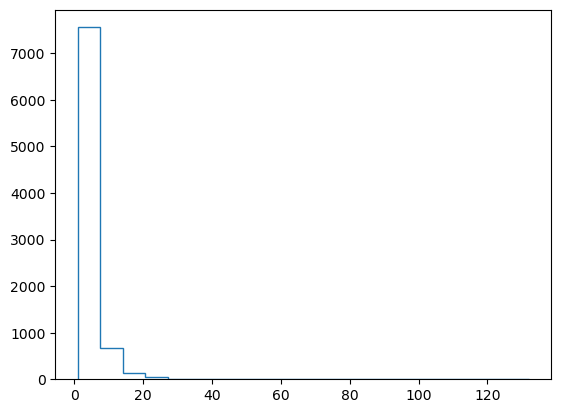

In [37]:
plt.stairs(counts[0:6],bins[0:7])

In [23]:
print(f"We have clear overdispersion with E[counts]={np.mean(raw_counts):0.2f} and Var[counts]={np.var(raw_counts):0.2f}")

We have clear overdispersion with E[counts]=3.64 and Var[counts]=22.04


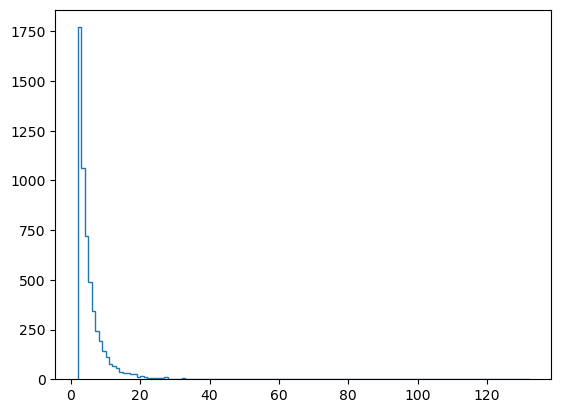

In [64]:
plt.stairs(np.unique(np.array(raw_counts_trunc), return_counts = True)[1][0:47], np.unique(np.array(raw_counts_trunc), return_counts = True)[0])

In [66]:
print(f"When truncated E[counts]={np.mean(raw_counts_trunc):0.2f} and Var[counts]={np.var(raw_counts_trunc):0.2f}")

When truncated E[counts]=5.03 and Var[counts]=28.09


# Attempt merge to percentages

In [127]:
evs_bg_merge = evs_grouped.merge(mun_evs_zipgroups[["Postal", "GEOID", "pct_within_zip"]],
                                 left_on = "ZIP_CODE",
                                 right_on = "Postal",
                                 how = "outer")

,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price,Postal,GEOID,pct_within_zip
0,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003460e+10,0.009259
1,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.003086
2,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.104938
3,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.064815
4,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.037037
...,...,...,...,...,...,...,...,...,...,...,...,...
793,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003462e+10,0.064815
794,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003462e+10,0.157407
795,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003462e+10,0.145062
796,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003466e+10,0.012346


In [136]:
evs_bg_merge[(evs_bg_merge["ZIP_CODE"]==6001) & (evs_bg_merge["year"]==2018) & (evs_bg_merge["month"]==1)]

,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price,Postal,GEOID,pct_within_zip
0,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003460e+10,0.009259
1,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.003086
2,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.104938
3,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.064815
4,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.037037
5,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.067901
6,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.169753
7,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.117284
8,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.043210
9,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.064815


# Covariates prepare

In [28]:
income_data_path = data_path / "data_for_poisson" / "ACSS1901 - Income - By ZCTA"

In [29]:
income_df = pd.DataFrame()

for file in income_data_path.iterdir():
    # Get the year
    year = file.name[7:11]

    # Read in the file and get the median income
    f = pd.read_csv(file)
    f = f.iloc[[11]].T.reset_index()
    f = f.loc[f["index"].str.contains("Households!!Estimate")]

    # Get the zip code and year, and rename columns
    f["index"] = f["index"].str[6:11].astype(int)
    f["year"] = year
    f = f.rename(columns = {"index" : "zip", 11: "median_income"}).reset_index(drop = True)

    # Append to the master df
    income_df = pd.concat([income_df, f]).reset_index(drop = True)

In [26]:
population_data_path = data_path / "data_for_poisson" / "ACSB01003 - Total Population - By ZCTA"

In [27]:
population_df = pd.DataFrame()

for file in population_data_path.iterdir():
    # Get the year
    year = file.name[7:11]

    # Read in the file and get the population
    f = pd.read_csv(file)
    f = f.T.reset_index()
    f = f.loc[f["index"].str.contains("Estimate")]

    # Get the zip code and year, and rename columns
    f["index"] = f["index"].str[6:11].astype(int)
    f["year"] = year
    f = f.rename(columns = {"index" : "zip", 0: "population"}).reset_index(drop = True)

    # Append to the master df
    population_df = pd.concat([population_df, f]).reset_index(drop = True)

In [2]:
education_data_path = data_path / "data_for_poisson" / "ACSS1501 - Educational Attainment - By ZCTA"

In [24]:
education_data_df = pd.DataFrame()

In [25]:
for file in education_data_path.iterdir():
    # Get the year
    year = file.name[7:11]

    # Read in the file and get the population
    f = pd.read_csv(file, skiprows =[0])
    col1 = "Geographic Area Name"
    col2 = "Estimate!!Percent!!Population 25 years and over!!High school graduate (includes equivalency)"
    col2a = "Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency)"
    
    try:
        f = f[[col1, col2]]
    except:
        f = f[[col1, col2a]]

    f = f.rename(columns = {f.columns[0]:"zip", f.columns[1]:"pct_over25_hs"}).reset_index(drop=True)
    f["zip"] = f["zip"].str[6:].astype(int)
    f["year"] = year
    education_data_df = pd.concat([education_data_df, f]).reset_index(drop=True)

In [23]:
education_data_df

,zip,pct_over25_hs,year
0,06001,10.3,2017
1,06002,28.3,2017
2,06010,35.3,2017
3,06013,22.2,2017
4,06016,25.3,2017
...,...,...,...
2827,6902,21.8,2021
2828,6903,8.5,2021
2829,6905,15.4,2021
2830,6906,27.2,2021


# Getting right columns

In [9]:
education_cols = []
for file in education_data_path.iterdir():
    f = pd.read_csv(file, skiprows = [0])
    cols = f.columns.tolist()
    a = [x for x in cols if "Percent" in x and "High school graduate" in x and not"Annotation" in x and not "Margin" in x and not "RACE" in x]
    a = [x for x in a if "25 years and over" in x]
    a = [x for x in a if not "Male" in x and not "Female" in x]
    a = [x for x in a if not "to" in x]
    education_cols.append([a])

In [10]:
education_cols

[[['Estimate!!Percent!!Population 25 years and over!!High school graduate (includes equivalency)',
   'Estimate!!Percent!!Population 25 years and over!!Population 65 years and over!!High school graduate or higher',
   'Estimate!!Percent!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!High school graduate (includes equivalency)']],
 [['Estimate!!Percent!!Population 25 years and over!!High school graduate (includes equivalency)',
   'Estimate!!Percent!!Population 25 years and over!!High school graduate or higher',
   'Estimate!!Percent!!Population 25 years and over!!Population 65 years and over!!High school graduate or higher',
   'Estimate!!Percent!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!High school graduate (includes equivalency)']],
 [['Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school gradua